In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys,os
sys.path.append('..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.strategy import StrategyBase, OptParam, OptParamArray
from backtester.swarms.ranking import SwarmRanker
from backtester.swarms.rebalancing import SwarmRebalance
from backtester.swarms.filters import SwarmFilter
from backtester.costs import CostsManagerEXOFixed
from backtester.exoinfo import EXOInfo
from backtester.swarms.rankingclasses import *
from backtester.swarms.swarm import Swarm


import pandas as pd
import numpy as np
import scipy

In [3]:
from strategies.strategy_renko_no_exit_on_patterns import StrategyRenkoPatterns_no_exit_on_patterns

In [1]:
from scripts.settings import *
try:
    from scripts.settings_local import *
except:
    pass

from exobuilder.data.exostorage import EXOStorage

storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)


exo_filter = '*'     # All 
#exo_filter = 'ES_'  # ES only
exo_filter = 'ES*Collar'  # ES Collars (incl Bearish, Bullish, BW and vanilla)

[print(exo) for exo in storage.exo_list(exo_filter)];

ES_BullishCollarBW
ES_BearishCollarBW
ES_BullishCollar


## Script settings

In [4]:
STRATEGY_CONTEXT = {
    'strategy': { 
        'class': StrategyRenkoPatterns_no_exit_on_patterns,
        'exo_name': 'ES_BearishCollarBW',        # <---- Select and paste EXO name from cell above
        'exo_storage': storage,        
        'opt_params': [
                        #OptParam(name, default_value, min_value, max_value, step)
                        OptParamArray('Direction', [1]),
                        OptParam('BoxSize', 500, 100, 1000, 50),
                        OptParam('MoveCount', 2, 2, 2, 1),
                        OptParamArray('RulesIndex', np.arange(9)),
                        OptParam('MedianPeriod', 5, 1, 20, 2)
            
            ],
    },
    'swarm': {
        'members_count': 5,
        'ranking_class': RankerBestWithCorrel(window_size=-1, correl_threshold=0.5),
        'rebalance_time_function': SwarmRebalance.every_friday,

    },
    'costs':{
        'manager': CostsManagerEXOFixed,
        'context': {
            'costs_options': 3.0,
            'costs_futures': 3.0,
        }
    }
}

# Backtest class based strategy

In [5]:
smgr = Swarm(STRATEGY_CONTEXT)
smgr.run_swarm()
smgr.pick()

# Saving results to swarms directory
smgr.save('./swarms/')

### WARNING! Loading swarm from file (don't run next cell if you want new swarm instance)

In [6]:
#smgr = Swarm.load(strategy_context=STRATEGY_CONTEXT, directory='./swarms/')
#print('Loading: '+smgr.get_swarm_name())

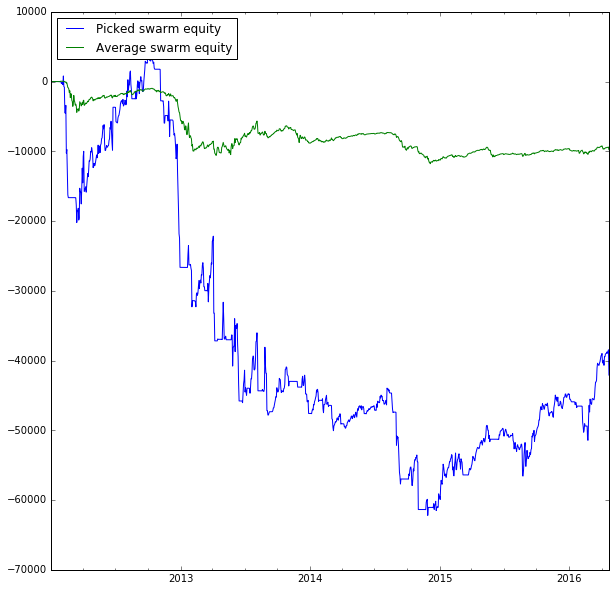

In [7]:
figsize(10,10)
smgr.picked_equity.plot(label='Picked swarm equity');
smgr.raw_equity.plot(label='Average swarm equity');
legend(loc=2);

In [ ]:
smgr.raw_swarm.plot(legend=False)

In [ ]:
#
# To export swarms above to .csv, uncomment this
#

#swarm_df = smgr.swarm
#swarm_df.to_csv('./temp_swarms/ichi_swarm.csv')

In [ ]:
figsize(10,10)
smgr.picked_equity.plot(label='Picked swarm equity');
smgr.raw_equity.plot(label='Average swarm equity');
legend(loc=2);

In [ ]:
smgr.picked_swarm.plot()

# Swarm exposure

In [ ]:
smgr.picked_exposure.sum(axis=1).rolling(10).mean().plot()

# Swarm statistics

#### Non-picked swarm stats

In [ ]:
smgr.picked_stats

## Exo information

In [ ]:
smgr.strategy.exoinfo.exo_info

In [ ]:
smgr.strategy.exoinfo.data.exo.plot()

### Global filter information (obsolete)


## Costs information (per 1-exo unit)

In [ ]:
figsize(10,5)
smgr.strategy.costs.plot()

## Margin graphs

### EXO Margin (per 1 EXO unit)

In [ ]:
smgr.strategy.exoinfo.margin().plot()

# Saving results

In [ ]:
smgr.save('./swarms/')